Set up a model optimisation pipeline. With all 10 parameters of the Izhikevich free.

Experimental constraints are simulated.

In [1]:
%%capture

import bluepyopt as bpop
import bluepyopt.ephys as ephys
import pickle
from sciunit.scores import ZScore
from sciunit import TestSuite
from sciunit.scores.collections import ScoreArray
import sciunit
import numpy as np
from neuronunit.optimisation.optimization_management import dtc_to_rheo, switch_logic,active_values
from neuronunit.tests.base import AMPL, DELAY, DURATION

import quantities as pq
PASSIVE_DURATION = 500.0*pq.ms
PASSIVE_DELAY = 200.0*pq.ms
import matplotlib.pyplot as plt
from bluepyopt.ephys.models import ReducedCellModel
import numpy
from neuronunit.optimisation.optimization_management import test_all_objective_test
from neuronunit.optimisation.optimization_management import check_binary_match, three_step_protocol,inject_and_plot_passive_model
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
import numpy as np


simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=MODEL_PARAMS["IZHI"],backend="IZHI")  
simple_cell.backend = "IZHI"

model = simple_cell
model.params = {k:np.mean(v) for k,v in model.params.items() }

from sciunit.scores import ZScore
tests = pickle.load(open("processed_multicellular_constraints.p","rb"))
nu_tests = tests['Hippocampus CA1 pyramidal cell'].tests
nu_tests[0].score_type = ZScore

nu_tests, OM, target = test_all_objective_test(MODEL_PARAMS["IZHI"],model_type="IZHI",protocol={'allen':False,'elephant':True})




nu_tests = list(nu_tests.values())
nu_tests[0].score_type = ZScore
target = three_step_protocol(target)
target.rheobase
target.everything;


Contrive code pipeline such that threshold measurement and NU error functions derived from threshold measurements do not guide optimization error signal. Threshold measurements do not participate in optimization whatsoever.

In [2]:
import copy
whole_suite = copy.copy(nu_tests)
nu_tests = nu_tests[0:4]
nu_tests

In [3]:






def initialise_test(v,rheobase):
    v = switch_logic([v])
    v = v[0]
    k = v.name
    if not hasattr(v,'params'):
        v.params = {}
    if not 'injected_square_current' in v.params.keys():    
        v.params['injected_square_current'] = {}
    if v.passive == False and v.active == True:
        keyed = v.params['injected_square_current']
        v.params = active_values(keyed,rheobase)
        v.params['injected_square_current']['delay'] = DELAY
        v.params['injected_square_current']['duration'] = DURATION
    if v.passive == True and v.active == False:

        v.params['injected_square_current']['amplitude'] =  -10*pq.pA
        v.params['injected_square_current']['delay'] = PASSIVE_DELAY
        v.params['injected_square_current']['duration'] = PASSIVE_DURATION

    if v.name in str('RestingPotentialTest'):
        v.params['injected_square_current']['delay'] = PASSIVE_DELAY
        v.params['injected_square_current']['duration'] = PASSIVE_DURATION
        v.params['injected_square_current']['amplitude'] = 0.0*pq.pA    
        
    return v

class NUFeature_standard_suite(object):
    def __init__(self,test,model):
        self.test = test
        self.model = model
    def calculate_score(self,responses):
        model = responses['model'].dtc_to_model()
        model.attrs = responses['params']
        
        ##
        # Last 4 lines entered
        ##
        if responses['rheobase'] is None:
            return 100.0
        if type(responses['rheobase']) is type(dict()):
            if responses['rheobase']['value'] is None:
                return 100.0
        self.test = initialise_test(self.test,responses['rheobase'])
        #if "RestingPotential" in str(self.test.name):            
        #    print(self.test.observation,self.test.prediction)
        if "Rheobase" in str(self.test.name):
            prediction = {'value':responses['rheobase']}

            score_gene = self.test.compute_score(self.test.observation,prediction)
            try:

                lns = np.abs(score_gene.log_norm_score)
            except:
                # works 1/2 time that log_norm_score does not work
                # more informative than nominal bad score 100
                #lns = float(score_gene.raw)

                lns = np.abs(float(score_gene.raw))
            return lns

        else:
            try:
                score_gene = self.test.judge(model)
            except:
                return 100.0

        if not isinstance(type(score_gene),type(None)):
            if not isinstance(score_gene,sciunit.scores.InsufficientDataScore):
                if not isinstance(type(score_gene.log_norm_score),type(None)):
                    try:

                        lns = np.abs(score_gene.log_norm_score)
                    except:
                        # works 1/2 time that log_norm_score does not work
                        # more informative than nominal bad score 100
                        lns = np.abs(score_gene.raw)
                else:
                    # works 1/2 time that log_norm_score does not work
                    # more informative than nominal bad score 100

                    lns = np.abs(score_gene.raw)
            else:
                prediction = self.test.generate_prediction(model)
                lns = 100
        if lns==np.inf:
            

            lns = float(score_gene.raw)
        return lns

    
objectives = []
#for protocol in sweep_protocols:
#    stim_start = protocol.stimuli[0].step_delay
#    stim_end = stim_start + protocol.stimuli[0].step_duration
    
for tt in nu_tests:
    feature_name = '%s.%s' % (tt.name, tt.name)
    ft = NUFeature_standard_suite(tt,model)
    objective = ephys.objectives.SingletonObjective(
        feature_name,
        ft)
    objectives.append(objective)

score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 
        
        
#objectives[0]        



# ### Creating the cell evaluator
# 
# We will need an object that can use these objective definitions to calculate the scores from a protocol response. This is called a ScoreCalculator.




lop={}
from bluepyopt.parameters import Parameter
for k,v in MODEL_PARAMS["IZHI"].items():
    p = Parameter(name=k,bounds=v,frozen=False)
    lop[k] = p

print(lop)
simple_cell.params = lop

nu_tests[0].judge(simple_cell)

nu_tests[0].score_type = ZScore


# Combining everything together we have a CellEvaluator. The CellEvaluator constructor has a field 'parameter_names' which contains the (ordered) list of names of the parameters that are used as input (and will be fitted later on).
sweep_protocols = []
for protocol_name, amplitude in [('step1', 0.05)]:

    protocol = ephys.protocols.SweepProtocol(protocol_name, [None], [None])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

MODEL_PARAMS["IZHI"]
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model=simple_cell,
        param_names=MODEL_PARAMS["IZHI"].keys(),
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc,
        sim='euler')
simple_cell.params_by_names(MODEL_PARAMS["IZHI"].keys())
simple_cell.params;


# ### Evaluating the cell
# 
# The cell can now be evaluate for a certain set of parameter values.

# In[ ]:


#default_params = MODEL_PARAMS["IZHI"]
#print(cell_evaluator.evaluate_with_dicts())


# ## Setting up and running an optimisation
# 
# Now that we have a cell template and an evaluator for this cell, we can set up an optimisation.
import dask
def dask_map_function(eval_,invalid_ind):
    results = []
    for x in invalid_ind:
        y = dask.delayed(eval_)(x)
        results.append(y)
    fitnesses = dask.compute(*results)
    return fitnesses


#for mut,cxp in zip(range(0.1,0.1,1),range(0.1,0.1,1)):
MU =40
optimisation = bpop.optimisations.DEAPOptimisation(
        evaluator=cell_evaluator,
        offspring_size = MU,
        map_function = dask_map_function,
        selector_name='IBEA',
        mutpb=0.015,
        cxpb=0.35)


# And this optimisation can be run for a certain number of generations



final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=200)



{'C': <bluepyopt.parameters.Parameter object at 0x7f7048a0d290>, 'k': <bluepyopt.parameters.Parameter object at 0x7f7048a0d590>, 'vr': <bluepyopt.parameters.Parameter object at 0x7f7048a0d5d0>, 'vt': <bluepyopt.parameters.Parameter object at 0x7f7048a0d610>, 'vPeak': <bluepyopt.parameters.Parameter object at 0x7f7048a0d650>, 'a': <bluepyopt.parameters.Parameter object at 0x7f7048a0d690>, 'b': <bluepyopt.parameters.Parameter object at 0x7f7048a0d6d0>, 'c': <bluepyopt.parameters.Parameter object at 0x7f7048a0d710>, 'd': <bluepyopt.parameters.Parameter object at 0x7f7048a0d750>}


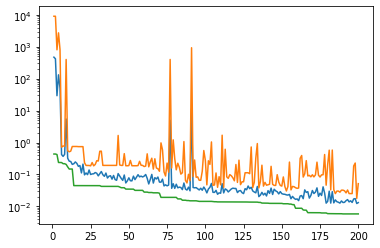

In [5]:


gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')

plt.plot(gen_numbers,avg_fitness, label='avg fitness')
plt.plot(gen_numbers,max_fitness, label='max fitness')
plt.plot(gen_numbers,min_fitness, label='min fitness')
plt.semilogy()
plt.show()

In [6]:
best_ind = hall_of_fame[0]
best_ind_dict = cell_evaluator.param_dict(best_ind)
model = cell_evaluator.cell_model
cell_evaluator.param_dict(best_ind)
model.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}
opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}
opt.tests = whole_suite
obs_preds = opt.make_pretty(whole_suite)


In [9]:
#print(dir(opt.SA))
opt.SA.to_frame()


,0
RheobaseTest,0.001029
TimeConstantTest,0.000024
RestingPotentialTest,0.000137
InputResistanceTest,0.004621
CapacitanceTest,0.006196
InjectedCurrentAPWidthTest,0.054332
InjectedCurrentAPAmplitudeTest,0.024373
InjectedCurrentAPThresholdTest,0.010911


In [10]:
obs_preds

,observations,predictions
0,195.3369140625 pA,195.556640625 pA
1,2.850108706261936 ms,2.850282217981474 ms
2,-65.79733759632016 mV,-65.79621535303939 mV
3,29535464.91850147 kg*m**2/(s**3*A**2),29086904.781316034 kg*m**2/(s**3*A**2)
4,9.649784468016226e-11 s**4*A**2/(kg*m**2),9.799193965156279e-11 s**4*A**2/(kg*m**2)
5,0.0009800000000000002 s,0.00111 s
6,79.57077470720151 mV,74.76756729602295 mV
7,-37.679548213047035 mV,-36.654553344357645 mV


(AnalogSignal with 1 channels of length 80000; units mV; datatype float64 
 sampling rate: 100.0 1/ms
 time: 0.0 s to 0.8 s,
 <module 'matplotlib.pyplot' from '/home/user/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>)

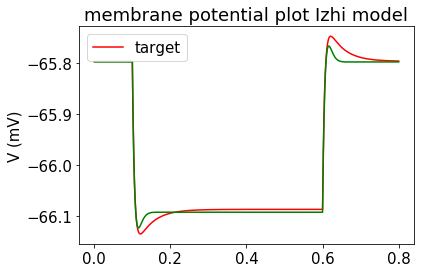

In [11]:
#check_binary_match(target,opt,snippets=False,plotly=False)
inject_and_plot_passive_model(opt,second=target,plotly=False)
#check_binary_match(target,opt,snippets=True,plotly=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



def hof_to_euclid(hof,MODEL_PARAMS,target):
    lengths = {}
    tv = 1
    cnt = 0
    constellation0 = hof[0]
    constellation1 = hof[1]
    tg = target.dtc_to_gene()
    print(tg)
    if len(MODEL_PARAMS)==1:
        
        ax = plt.subplot()
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))

            x = [h[cnt] for h in hof]
            y = [0 for h in hof]
            ax.set_xlim(v[0],v[1])
            ax.set_xlabel(k)
            tgene = tg[cnt]
            yg = 0

            #if cnt==1:
            #    y = [h[cnt] for h in hof]
            #    ax.set_ylim(v[0],v[1])
            #    ax.set_ylabel(k)
            #cnt+=1

        ax.scatter(x, y, c='b', marker='o',label='samples')
        ax.scatter(tgene, yg, c='r', marker='*',label='target')
        ax.legend()

        plt.show()
    
    
    if len(MODEL_PARAMS)==2:
        
        ax = plt.subplot()
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))
                
            if cnt==0:
                tgenex = tg[cnt]
                x = [h[cnt] for h in hof]
                ax.set_xlim(v[0],v[1])
                ax.set_xlabel(k)
            if cnt==1:
                tgeney = tg[cnt]

                y = [h[cnt] for h in hof]
                ax.set_ylim(v[0],v[1])
                ax.set_ylabel(k)
            cnt+=1

        ax.scatter(x, y, c='r', marker='o',label='samples',s=5)
        ax.scatter(tgenex, tgeney, c='b', marker='*',label='target',s=11)

        ax.legend()

        plt.show()
    
    if len(MODEL_PARAMS)==3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))

            if cnt==0:
                x = [h[cnt] for h in hof]
                ax.set_xlim(v[0],v[1])
                ax.set_xlabel(k)
            if cnt==1:
                y = [h[cnt] for h in hof]
                ax.set_ylim(v[0],v[1])
                ax.set_ylabel(k)
            if cnt==2:
                z = [h[cnt] for h in hof]
                ax.set_zlim(v[0],v[1])
                ax.set_zlabel(k)

            cnt+=1

        ax.scatter(x, y, z, c='r', marker='o')
        plt.show()
        

gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')

plt.clf()
plt.plot(gen_numbers, max_fitness, label='max fitness')
plt.plot(gen_numbers, avg_fitness, label='avg fitness')
plt.plot(gen_numbers, min_fitness, label='min fitness')

plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.yscale('log')

plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
#plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

In [ ]:
len(MODEL_PARAMS['IZHI'])
print(dir(hist))

In [ ]:
hof_to_euclid(hall_of_fame,MODEL_PARAMS['IZHI'],target)
hof_to_euclid(list(hist.genealogy_history.values()),MODEL_PARAMS['IZHI'],target)

In [ ]:
opt = model.model_to_dtc()
opt = dtc_to_rheo(dtc)

In [ ]:

def plot_score_history(logbook,weights):
    """Plot the history of each of the scores over generations."""
    rows = 2
    cols = math.ceil((len(weights) + 1) / 2)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
    scores = [x["best"][0] for x in logbook]
    axes[0, 0].plot(scores)
    axes[0, 0].set_title("Total")
    for j, (feature, stat, weight) in enumerate(weights):
        ax = axes.flat[j + 1]
        history = [x["best"][j + 1] for x in logbook]
        ax.plot(history)
        ax.set_title(feature)
    axes[0, 0].set_xlabel("Generation")
    plt.tight_layout()


# The optimisation has return us 4 objects: final population, hall of fame, statistical logs and history. 
# 
# The final population contains a list of tuples, with each tuple representing the two parameters of the model


print('Final population: ', final_pop)


# The best individual found during the optimisation is the first individual of the hall of fame

best_ind = hall_of_fame[0]
print('Best individual: ', best_ind)
print('Fitness values: ', best_ind.fitness.values)


# We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dict of the parameters


best_ind_dict = cell_evaluator.param_dict(best_ind)
print(cell_evaluator.evaluate_with_dicts(best_ind_dict))


model = cell_evaluator.cell_model
cell_evaluator.param_dict(best_ind)
model.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}



opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}

check_binary_match(target,opt)
inject_and_plot_passive_model(opt,second=target)


# As you can see the evaluation returns the same values as the fitness values provided by the optimisation output. 
# We can have a look at the responses now.

# In[ ]:


#plot_responses(twostep_protocol.run(cell_model=simple_cell, param_values=best_ind_dict, sim=nrn))
 


# Let's have a look at the optimisation statistics.
# We can plot the minimal score (sum of all objective scores) found in every optimisation. 
# The optimisation algorithm uses negative fitness scores, so we actually have to look at the maximum values log.

gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 

In [ ]:
from numpy import linalg as LA
def hof_to_euclid(hof,MODEL_PARAMS):
    lengths = {}
    tv = 1
    for k,v in MODEL_PARAMS.items():
        lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))
        tv = tv*lengths[k]
    cnt=0
    for k,v in MODEL_PARAMS.items():        
        cnt+=1
        distance_per_paramater[k] = ((sum(hof[0][cnt]-hof[1][cnt])**2)**0.5)/lengths[k]
    
    #distance_between_genes = sum((x - y) ** 2 for (x, y) in zip(constellation0, constellation1)) ** 0.5
    
    return distance_per_paramater[k]
distance_between_genes = hof_to_euclid(hall_of_fame,MODEL_PARAMS['IZHI'])
distance_between_genes

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



def hof_to_euclid(hof,MODEL_PARAMS):
    lengths = {}
    tv = 1
    cnt = 0
    constellation0 = hof[0]
    constellation1 = hof[1]
    if len(MODEL_PARAMS)==2:
        
        ax = plt.subplot()
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))

            if cnt==0:
                x = [h[cnt] for h in hof]
                ax.set_xlim(v[0],v[1])
                ax.set_xlabel(k)
            if cnt==1:
                y = [h[cnt] for h in hof]
                ax.set_ylim(v[0],v[1])
                ax.set_ylabel(k)
            cnt+=1

        ax.scatter(x, y, c='r', marker='o')
        plt.show()
    
    if len(MODEL_PARAMS)==3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))

            if cnt==0:
                x = [h[cnt] for h in hof]
                ax.set_xlim(v[0],v[1])
                ax.set_xlabel(k)
            if cnt==1:
                y = [h[cnt] for h in hof]
                ax.set_ylim(v[0],v[1])
                ax.set_ylabel(k)
            if cnt==2:
                z = [h[cnt] for h in hof]
                ax.set_zlim(v[0],v[1])
                ax.set_zlabel(k)

            cnt+=1

        ax.scatter(x, y, z, c='r', marker='o')
        plt.show()
hof_to_euclid(hall_of_fame,MODEL_PARAMS['IZHI'])

In [ ]:
print(hall_of_fame[0])
print(hall_of_fame[1])
for h in hall_of_fame:
    print(h)

In [ ]:
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')

plt.clf()
plt.plot(gen_numbers, max_fitness, label='max fitness')
plt.plot(gen_numbers, avg_fitness, label='avg fitness')
plt.plot(gen_numbers, min_fitness, label='min fitness')

plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.yscale('log')

plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
#plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

In [ ]:
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')

plt.clf()
fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(1,1)

plt.plot(gen_numbers, min_fitness, label='min fitness')
#ax.semilogy()
#ax.set_yscale('log')
plt.yscale('log')

plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
#plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

In [ ]:
inject_and_plot_passive_model(opt,second=target,plotly=False)

In [ ]:
check_binary_match(opt,target,plotly=False,snippets=False)
check_binary_match(opt,target,plotly=False,snippets=True)

In [ ]:
best_ind_dict = cell_evaluator.param_dict(best_ind)
objectives = cell_evaluator.evaluate_with_dicts(best_ind_dict)

In [ ]:
objectives

In [ ]:
opt = dtc_to_rheo(opt)
print(opt.rheobase)

In [ ]:
target.rheobase

In [ ]:
params = {}
params['injected_square_current'] = {}
#if v.name in str('RestingPotentialTest'):
params['injected_square_current']['delay'] = PASSIVE_DELAY
params['injected_square_current']['duration'] = PASSIVE_DURATION
params['injected_square_current']['amplitude'] = 0.0*pq.pA    

In [ ]:

opt_model = opt.dtc_to_model()
opt_model.inject_square_current(params)
opt_vm = opt_model.get_membrane_potential()
opt_vm[-1]

In [ ]:
target_model = target.dtc_to_model()
target_model.inject_square_current(params)
target_vm = target_model.get_membrane_potential()
target_vm[-1]

In [ ]:
best_ind = hall_of_fame[1]
print('Best individual: ', best_ind)
print('Fitness values: ', best_ind.fitness.values)


# We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dict of the parameters


best_ind_dict = cell_evaluator.param_dict(best_ind)
print(cell_evaluator.evaluate_with_dicts(best_ind_dict))


model = cell_evaluator.cell_model
dtc= model.model_to_dtc()
opt = dtc_to_rheo(opt)
print(opt.rheobase)

In [ ]:
#model.rheobase

In [ ]:
len(hist.genealogy_history)/20

In [ ]:
import pandas as pd
import seaborn as sns
logbook = logs
#scores = [ m for m in logs ]
'''
list_of_dicts = []
df1 = pd.DataFrame()
genes=[]
for _,v in hist.genealogy_history.items():
    genes.append(v.fitness.values)
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)

'''
MU =20
genes=[]
min_per_generations = []
for i,v in hist.genealogy_history.items():
    if i%25==0:
        min_per_gen = sorted([(gene,np.min(gene)) for gene in genes],key=lambda x: x[1])
        min_per_generations.append(min_per_gen[0][0])
        genes =[]
    genes.append(v.fitness.values)
df2 = pd.DataFrame()
scores = []
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    if j<len(min_per_generations):
        df2[index] = pd.Series(min_per_generations).values[j]#, index=df1.index)
        #scores.append(df2[str(i)])
df2    

#rescored = [np.sum(i) for i in range(0,len(scores)) ]
#rescored

In [ ]:
import math
import seaborn as sns
sns.set(style="darkgrid")

fig,axes = plt.subplots(3,3,figsize=(20,20))#math.ceil(len(objectives)/2+1),figsize=(20,20))
axes[0,0].plot(gen_numbers, min_fitness, label='min fitness')

axes[0,0].set_title('Observation/Prediction Disagreement')
for i,c in enumerate(df2.columns):
    ax = axes.flat[i+1]
    history = df2[c]
    #mn = mean[k.name] 
    #st = std[k.name] 
    #history = [(j[i]-mn)/st for j in scores ]
    #ax.axhline(y=mn , xmin=0.02, xmax=0.99,color='red',label='best candidate sampled')

    #ax.axvline(x=min_x , ymin=0.02, ymax=0.99,color='blue',label='best candidate sampled')
    ax.plot(history)
    ax.set_title(str(c))
    #bigger = np.max([np.max(history),mn])
    #smaller = np.max([np.min(history),mn])

    #ax.set_ylim([np.min(history),np.max(history)])
    #ax.set_ylabel(str(front[0].dtc.tests[i].observation['std'].units))
axes[0,0].set_xlabel("Generation")
axes[0,0].set_ylabel("standardized error")

plt.tight_layout()
#if figname is not None:
#    plt.savefig(figname)
#else:
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
logbook = logs
#scores = [ m for m in logs ]
list_of_dicts = []
df1 = pd.DataFrame()
genes=[]
for _,v in hist.genealogy_history.items():
    genes.append(v.fitness.values)
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)

df1=(df1-df1.mean())/df1.std()

corr = df1.corr()
fig =plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)
plt.show()


In [ ]:
print(np.sum(np.sum(corr)))